# Final Exam - Clustering robustness metric

## Winter 2023 - BIN710 Data Mining (UdeS)

Final exam as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── Examenfinal.ipynb   ---> Jupyter Notebook

└── IFT870_h2023_ExamenFinal_Complet.pdf    ---> Tasks to complete

### Dataset
Labeled faces in the wild (LFW)
- 1916 im (40 per objects max)
- 87x65 = 5655 resolution

URL : http://vis-www.cs.umass.edu/lfw/

### Goal
Implement intrinsic evaluation methods with 2 clustering algorithms (K-means (centroid) and DBSCAN (density)). Either test the robustness of the clustering by varying the hyperparams or introducting noise

---

Import libs

In [225]:
from typing import Dict, Union

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.cluster import KMeans, DBSCAN

## 0. Fetch LFW dataset

In [4]:
# Load the Labeled faces dataset
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [9]:
print(list(faces.keys()))

['data', 'images', 'target', 'target_names', 'DESCR']


In [18]:
faces["target"]

array([61, 25,  9, ..., 14, 15, 14])

Check images properties

In [17]:
# Check image format
print(f"Num images and im_array size: {faces['data'].shape}")
print(f"x_y images array: {faces['images'].shape}")


Num images and im_array size: (3023, 5655)
x_y images array: (3023, 87, 65)


In [27]:
# Image classes and labelling
print(f'Number objects with classes: {len(faces["target"])}')
print(f'Categorical value associated with label (first 5 example):\n {faces["target_names"][:5]}')

Number objects with classes: 3023
Categorical value associated with label (first 5 example):
 ['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie']


Printing an image

5655
[0.22352941 0.23137255 0.29411766 ... 0.06797386 0.06405229 0.09150327]
61
Winona Ryder


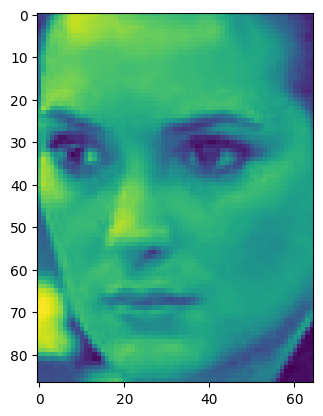

In [54]:
plt.imshow(faces.images[0])
print(len(faces.data[0]))
print(faces.data[0])
print(faces.target[0])
print(faces.target_names[faces.target[0]])

Printing first 10 entries with names + faces (using imshow)

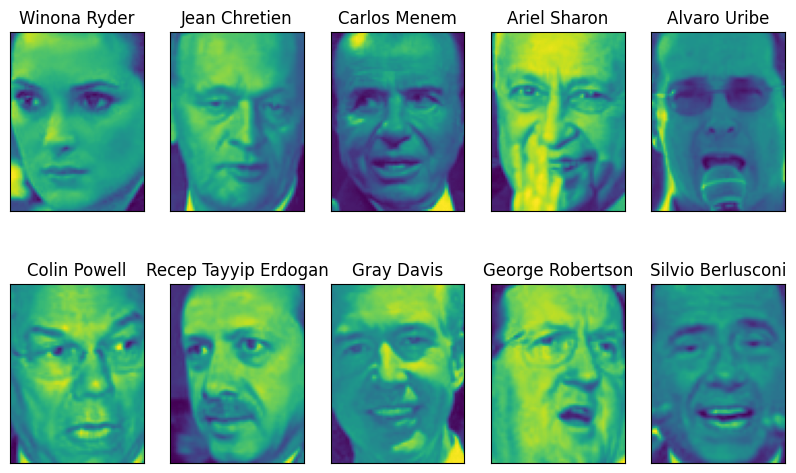

In [55]:
# Get faces for first 10 entry in db
fig, axes = plt.subplots(2, 5, figsize=(10, 6), subplot_kw={'xticks': (), 'yticks': ()})
for name, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[name])

Saving a count table of name labels as dict

In [43]:
names_count = {}
labels_count = np.bincount(faces["target"])

for i, name in enumerate(faces["target_names"]):
    names_count[name] = labels_count[i]


We see a class imbalance in the dataset

In [53]:
# Print first 5
print({name: count for name, count in list(names_count.items())[:5]})

{'Alejandro Toledo': 39, 'Alvaro Uribe': 35, 'Amelie Mauresmo': 21, 'Andre Agassi': 36, 'Angelina Jolie': 20}


Some with higher than 40 image per labels

In [58]:
for name, count in names_count.items():
    if count > 40:
        print(name)

Ariel Sharon
Arnold Schwarzenegger
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Gloria Macapagal Arroyo
Hugo Chavez
Jacques Chirac
Jean Chretien
Jennifer Capriati
John Ashcroft
Junichiro Koizumi
Laura Bush
Lleyton Hewitt
Luiz Inacio Lula da Silva
Serena Williams
Tony Blair
Vladimir Putin


Reduce our dataset to a maximum of 40 images per label

In [68]:
# Initialize empty arr
keep40 = np.zeros(faces["target"].shape, dtype=bool)

# Loop through each label and keep up to 40 images per label
for label in np.unique(faces["target"]):
    keep40[np.where(faces["target"] == label)[0][:40]] = 1

# Save filtered dataset
X_faces, y_faces, X_images = faces["data"][keep40], faces["target"][keep40], faces["images"][keep40]

In [87]:
# Sanity check
print(f"keep40 data array: {X_faces.shape}")
print(f"keep40 x_y image shapes: {X_images.shape}")
print(f"Number of labels: {len(np.unique(y_faces))}")
print(f"Number of objects: {len(y_faces)}")


keep40 data array: (1916, 5655)
keep40 x_y image shapes: (1916, 87, 65)
Number of labels: 62
Number of objects: 1916


In [88]:
np.bincount(y_faces)

array([39, 35, 21, 36, 20, 40, 40, 24, 29, 21, 40, 31, 40, 22, 40, 40, 40,
       26, 30, 22, 39, 40, 20, 28, 40, 40, 21, 40, 21, 24, 20, 40, 31, 23,
       28, 40, 32, 40, 22, 40, 40, 29, 33, 20, 22, 37, 20, 22, 30, 27, 32,
       26, 23, 40, 33, 23, 25, 33, 40, 32, 40, 24])

In [89]:
names_count_keep40 = {}
labels_count_keep40 = np.bincount(y_faces)

for i, name in enumerate(faces["target_names"]):
    names_count_keep40[name] = labels_count_keep40[i]

In [99]:
pd.DataFrame(list(names_count_keep40.items()), columns=['Name', 'Count'])

,Name,Count
0,Alejandro Toledo,39
1,Alvaro Uribe,35
2,Amelie Mauresmo,21
3,Andre Agassi,36
4,Angelina Jolie,20
...,...,...
57,Tom Ridge,33
58,Tony Blair,40
59,Vicente Fox,32
60,Vladimir Putin,40


In [101]:
for name, count in names_count_keep40.items():
    if count > 40:
        print(name)

## Question2. Clustering robustness to changes in hyperparameters of K-Means and DBScan algorithms

### A. Function to calculate robustness to n_clusters changes in K-Means

In [130]:
len(X_faces)

1916

In [152]:
def calculate_robustness_kmeans(X: np.ndarray, km_instance: sklearn.cluster._kmeans.KMeans, n_clusters: int) -> float:
    """
    Calculate the robustness score for a KMeans instance by varying the n_clusters parameter.

    Parameters
    ----------
    X : np.ndarray
        The data matrix to fit the KMeans model on.
    km_instance : sklearn.cluster._kmeans.KMeans
        An instance of the KMeans class from scikit-learn.
    n_clusters : int
        The number of clusters to use as the base value when varying the n_clusters parameter.

    Returns
    -------
    float
        The robustness score for the KMeans instance.

    Raises
    ------
    TypeError
        If n_clusters is not an integer.
    ValueError
        If n_clusters is not greater than 1.
    """

    # Validate n_clusters
    try:
        n_clusters = int(n_clusters)
    except:
        raise TypeError("n_clusters must be an interger")
    
    if not n_clusters > 1:
        raise ValueError("n_clusters must be greater than 1")
    
    # Get list of n_clusters to train all kmeans models with
    n_clusters_variation = list(range(-5, 6))

    n_clusters_to_eval = [n_clusters + i for i in n_clusters_variation]

    # Get clusterings for each k to evaluate
    clusterings = []
    for k in n_clusters_to_eval:
        
        # Reset KMeans instance with k to eval and fit
        km = km_instance.set_params(n_clusters=k, n_init="auto")
        print(f"Training with k={km.n_clusters}...")
        km.fit(X)
        clusterings.append(km.labels_)
    
    print(f"Done clustering for all {n_clusters_to_eval}.\nNow calculating robustness of the clusterings")

    # Set the robustness equation components
    n = len(clusterings)
    m = len(X)
    P = set()
    count = {}

    # Check all pairs if present in same cluster in at least 2 clusterings
    for clustering in clusterings:
        for i in range(m):
            for j in range(i + 1,m):
                if clustering[i] == clustering[j]:
                    P.add((i, j))
                    # Adding all possible pair occurences in count dict
                    if (i, j) in count:
                        count[(i, j)] += 1
                    else:
                        count[(i, j)] = 1
    t = sum(count.values())

    R = t / (len(P) * n)
    print(f"Robustness for KMeans clustering with k={n_clusters_to_eval}: {R:.4f}")
    
    return R


Get Robustness scores for k=40, k=60, and k=80

In [155]:
k_to_test = [40, 60, 80]
robustness_kmeans_scores = {}

for k in k_to_test:
    robustness_kmeans_scores[f"k_{k}"] = calculate_robustness_kmeans(X_faces, KMeans(), k)

Training with k=35...
Training with k=36...
Training with k=37...
Training with k=38...
Training with k=39...
Training with k=40...
Training with k=41...
Training with k=42...
Training with k=43...
Training with k=44...
Training with k=45...
Done clustering for all [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45].
Now calculating robustness of the clusterings
Robustness for KMeans clustering with k=[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]: 0.2297
Training with k=55...
Training with k=56...
Training with k=57...
Training with k=58...
Training with k=59...
Training with k=60...
Training with k=61...
Training with k=62...
Training with k=63...
Training with k=64...
Training with k=65...
Done clustering for all [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65].
Now calculating robustness of the clusterings
Robustness for KMeans clustering with k=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]: 0.2054
Training with k=75...
Training with k=76...
Training with k=77...
Training with k=78...
Training w

In [158]:
print(robustness_kmeans_scores)

{'k_40': 0.22974049393907248, 'k_60': 0.20544217086735855, 'k_80': 0.19396443936815733}


Unexpectedly (to me at least), we have a higher rosbustness score for clusters around k = 40 -/+ 5. I would have expected the clusterings around 60 to be more similar since the true number of categories are 62. 

However, this just means that the KMeans model separates the cluster using features that are different that what the we initially perceive from the data. Some of the faces must share similar features even if they comme from different people, or maybe some different images from the same label have completely different features and more similar to other label (name/people) features.

### B. Function to calculate robustness to changes in Epsilon vals in DBSCAN algorithm

In [176]:
def calculate_robustness_dbscan(X: np.ndarray, DBSCAN_instance: sklearn.cluster._dbscan.DBSCAN, epsilon: float) -> float:
    """
    Calculate the robustness of DBSCAN clustering for a given epsilon value.

    Parameters
    ----------
    X : np.ndarray
        The data to cluster.
    DBSCAN_instance : sklearn.cluster._dbscan.DBSCAN
        An instance of the DBSCAN class from scikit-learn.
    epsilon : float
        The value of epsilon to use for the DBSCAN clustering.

    Returns
    -------
    float
        The robustness of the DBSCAN clustering for the given epsilon value.

    Raises
    ------
    TypeError
        If epsilon is not a float.
    ValueError
        If epsilon is not greater than 0.5.
    """
    
    # Validate epsilon
    try:
        epsilon = float(epsilon)
    except:
        raise TypeError("epsilon must be a float.")
    
    if not epsilon > 0.5:
        raise ValueError("epsilon value must be greater than 0.5 to avoid a negative value when testing with a -/+ 0.5 offset")
    
    # Get list of epsilon vals to train all DBSCAN models with
    epsilon_range = np.round(np.linspace(-0.5, 0.5, 11), decimals=1)

    epsilons_to_eval = [epsilon + e for e in epsilon_range]

    # Get clusterings for each eps to evaluate
    clusterings = []
    for e in epsilons_to_eval:
        
        # Reset DBSCAN instance with eps to eval and fit
        dbscan = DBSCAN_instance.set_params(eps=e, min_samples=3)
        print(f"Training with e={dbscan.eps}...")
        dbscan.fit(X)
        clusterings.append(dbscan.labels_)
    
    print(f"Done clustering for all eps={epsilons_to_eval}.\nNow calculating robustness of the clusterings")

    # Set the robustness equation components
    n = len(clusterings)
    m = len(X)
    P = set()
    count = {}

    # Check all pairs if present in same cluster in at least 2 clusterings
    for clustering in clusterings:
        for i in range(m):
            for j in range(i + 1, m):
                if clustering[i] == clustering[j]:
                    P.add((i, j))
                    # Adding all possible pair occurences in count dict
                    if (i, j) in count:
                        count[(i, j)] += 1
                    else:
                        count[(i, j)] = 1
    t = sum(count.values())

    R = t / (len(P) * n)
    print(f"Robustness for 11 DBSCAN clusterings with eps = {epsilon} -/+ 0.5 : R={R:.4f}")
    
    return R


In [186]:
# Evaluate robustness scores in DBSCAN algo
eps_to_test = [7, 8, 9]
robustness_dbscan_scores = {}

for eps in eps_to_test:
    robustness_dbscan_scores[f"eps_{eps}"] = calculate_robustness_dbscan(
        X=X_faces,
        DBSCAN_instance=DBSCAN(),
        epsilon=eps
    )

Training with e=6.5...
Training with e=6.6...
Training with e=6.7...
Training with e=6.8...
Training with e=6.9...
Training with e=7.0...
Training with e=7.1...
Training with e=7.2...
Training with e=7.3...
Training with e=7.4...
Training with e=7.5...
Done clustering for all eps=[6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5].
Now calculating robustness of the clusterings
Robustness for 11 DBSCAN clusterings with eps = 7.0 -/+ 0.5 : R=0.9477
Training with e=7.5...
Training with e=7.6...
Training with e=7.7...
Training with e=7.8...
Training with e=7.9...
Training with e=8.0...
Training with e=8.1...
Training with e=8.2...
Training with e=8.3...
Training with e=8.4...
Training with e=8.5...
Done clustering for all eps=[7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5].
Now calculating robustness of the clusterings
Robustness for 11 DBSCAN clusterings with eps = 8.0 -/+ 0.5 : R=0.8442
Training with e=8.5...
Training with e=8.6...
Training with e=8.7...
Training with e=8.8..

In [187]:
print(robustness_dbscan_scores)

{'eps_7': 0.9477492183224115, 'eps_8': 0.8442256017615171, 'eps_9': 0.7348196611484259}


Strongest robustness with epsilon of eps=7 -/+ 0.5 for 11 clusterings with a value of 94.78. It seams that the DBSCAN algo with the single change to the epsilon (radius around each data point to determine core points) is very robust, at least in the range of that hyperparameter change that we tested.

**However, it does not mean that DBSCAN is better than KMeans for our problem. It just means that the DBSCAN algo is less sensible to hyperparameter changes of epsilon (in the range that we tested) compared to KMeans with varying k's (also in the range with tested)**

## Question 3: Robustness to noise for K-Means and DBSCAN clustering algorithms

### A. Implementing a function that will generate noise and calculate robustness for either K-Means or DBSCAN algos

In [197]:
X_images.shape

(1916, 87, 65)

In [200]:
X_faces.shape[0]*1916/100

36710.56

In [302]:
isinstance(DBSCAN(), sklearn.cluster._dbscan.DBSCAN)

True

In [324]:
def robustness_to_noise(X_data: np.ndarray, clustering_instance: Union[sklearn.cluster._kmeans.KMeans, sklearn.cluster._dbscan.DBSCAN], hyperparam_value: float, noise_percent: int)-> float:
    """
    Calculates the robustness score of a clustering algorithm to noise introduction.

    Parameters
    ----------
    X_data : np.ndarray
        The data to cluster.
    clustering_instance : Union[]
        An instance of one of scikit-learn's clustering algorithms KMeans or DBSCAN
    hyperparam_value : float 
        The hyperparemeter value of the given clustering algorithm (k for KMeans and eps for DBSCAN)
    noise_percent : int
        The amount of noise to introduce in the dataset

    Returns
    -------
    float:
        The robustness score using the noise introduction
    
    Raises
    ------
    TypeError:
        If noise_percent is not an integer
    ValueError:
        If noise_percent is not between 1 and 99
    TypeError:
        If one of clustering_instance is not an instance of KMeans() or DBSCAN()

    """
    
    # Validate noise_percent
    try:
        noise_percent = int(noise_percent)
    except:
        raise TypeError("noise_percent must be an integer")
    
    if not 0 < noise_percent < 100:
        raise ValueError("noise_percent must fall within 1 and 99")
    
    # Selecting clustering algo
    kmeans = False
    dbscan = False

    if isinstance(clustering_instance, sklearn.cluster._kmeans.KMeans):
        kmeans = True
    elif isinstance(clustering_instance, sklearn.cluster._dbscan.DBSCAN):
        dbscan = True
    else:
        raise TypeError("Use one of default instances of KMeans() or DBSCAN() for clustering_instance")

    # Calculate mean and standard dev for each dimension/pixel
    mu = np.mean(X_data, axis=0, dtype=np.float64)
    sigma = np.std(X_data, axis=0, dtype=np.float64)

    # Calculate noise matrix size from data and noise percent
    noise_m = int(np.round(noise_percent/100*len(X_data)))
    noise_n = X_data.shape[1]

    # Generate noisy datasets by sampling from the normal distribution
    fixed_noisy_datasets = {}
    print(f"Generating 10 noisy datasets of size {noise_m} ({noise_percent}% of X dataset size)...")

    for i in range(10):
        np.random.seed(i)    # Avoid same noise for each generation
        noise_matrix = mu + sigma * np.random.randn(noise_m, noise_n)
        fixed_noisy_datasets[f"noise_{i}"] = noise_matrix

    # Perform clusterings with first entry as noiseless iteration
    clusterings = []
    if kmeans:
        km = clustering_instance.set_params(n_clusters=hyperparam_value, random_state=0, n_init="auto")
        print(f"Training first iteration with noiseless data using {km}")
        km.fit(X_data)
        clusterings.append(km.labels_)

    if dbscan:
        dbs = clustering_instance.set_params(eps=hyperparam_value, min_samples=3)
        print(f"Training first iteration with noiseless data using {dbs}")
        dbs.fit(X_data)
        clusterings.append(dbs.labels_)
    
    # Add noise to dataset (with noiseless iteration), train and calculate
    print("Performing clusterings with noisy datasets...")
    for noisy_set in fixed_noisy_datasets:
        if kmeans:
            km.fit(np.append(X_data, fixed_noisy_datasets[noisy_set], axis=0))
            clusterings.append(km.labels_)

        if dbscan:
            dbs.fit(np.append(X_data, fixed_noisy_datasets[noisy_set], axis=0))
            clusterings.append(dbs.labels_)

    # Calculate robustness score
    robust_n = len(clusterings)
    robust_m = len(X_data)
    robust_P = set()
    robust_count = {}

    # Check all pairs if present in same cluster in at least 2 clusterings
    print("Calculating robustness scores...")
    for clustering in clusterings:
        for i in range(robust_m):
            for j in range(i + 1, robust_m):
                if clustering[i] == clustering[j]:
                    robust_P.add((i, j))
                    # Adding all possible pair occurences in count dict
                    if (i, j) in robust_count:
                        robust_count[(i, j)] += 1
                    else:
                        robust_count[(i, j)] = 1
    t = sum(robust_count.values())

    R = t / (len(robust_P) * robust_n)
    print(f"Robustness for {str(clustering_instance)} with {noise_percent}% noise: \nR={R:.4f}\n")
    
    return R      
    

### B. Robustness of K-Means (for k=40, 60 and 80) to 5% noise

In [321]:
print(k_to_test)

[40, 60, 80]


In [332]:
robustness_noise_scores = {}

for k in k_to_test:
    robustness_noise_scores[f"kmeans_{k}"] = robustness_to_noise(
        X_data=X_faces,
        clustering_instance=KMeans(),
        hyperparam_value=k,
        noise_percent=5
    )

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using KMeans(n_clusters=40, n_init='auto', random_state=0)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for KMeans(n_clusters=40, n_init='auto', random_state=0) with 5% noise: 
R=0.2476

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using KMeans(n_clusters=60, n_init='auto', random_state=0)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for KMeans(n_clusters=60, n_init='auto', random_state=0) with 5% noise: 
R=0.2264

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using KMeans(n_clusters=80, n_init='auto', random_state=0)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for KMeans(n_clusters=80, n_init='auto', random_state=

In [333]:
print(robustness_noise_scores)

{'kmeans_40': 0.24763568477357586, 'kmeans_60': 0.22643555816456742, 'kmeans_80': 0.20949090659871278}


K-Means with k=40 is the most robust clustering model when introducing 5% noise over 10 iterations

### C. Robustness of DBSCAN (eps=7, 8, 9) to 5% noise

In [334]:
print(eps_to_test)

[7, 8, 9]


In [335]:
for eps in eps_to_test:
    robustness_noise_scores[f"dbscan_{eps}"] = robustness_to_noise(
        X_data=X_faces,
        clustering_instance=DBSCAN(),
        hyperparam_value=eps,
        noise_percent=5
    )

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using DBSCAN(eps=7, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=7, min_samples=3) with 5% noise: 
R=1.0000

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using DBSCAN(eps=8, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=8, min_samples=3) with 5% noise: 
R=1.0000

Generating 10 noisy datasets of size 96 (5% of X dataset size)...
Training first iteration with noiseless data using DBSCAN(eps=9, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=9, min_samples=3) with 5% noise: 
R=1.0000



In [330]:
print(robustness_noise_scores)

{'kmeans_40': 0.24763568477357586, 'kmeans_60': 0.22643555816456742, 'kmeans_80': 0.20949090659871278, 'dbscan_7': 1.0, 'dbscan_8': 1.0, 'dbscan_9': 1.0}


Robustness is the same accross all epsilon values so the clusterings are the same accross all the different clusterings (with noise introduction) regardless of the epsilon values. The DBSCAN algorithm is then less sensible to noise since it yields similar clusterings with even when introducing noise at each iteration.

## Question 4. Another noise generation model

Check a portion of the features distributions to observe its shape

In [392]:
# Check distributions
def get_distributions(data, min_feat, max_feat, nrows, ncols, fig_width, fig_height, feat_color=True, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    axes = axes.ravel()

    for i in range(min_feat, max_feat):
        if feat_color:
            plot = sns.histplot(data=data[:, i + 1], kde=kde, ax=axes[i - min_feat], bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data[:, i + 1], kde=kde, ax=axes[i - min_feat], bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"feature_{i}")
        plot.set(xlabel="")
        plot.set(ylabel="")

    fig.suptitle(f"Distributions for feature_{min_feat} to {max_feat}\n", weight="bold")
    fig.tight_layout()
    plt.show()


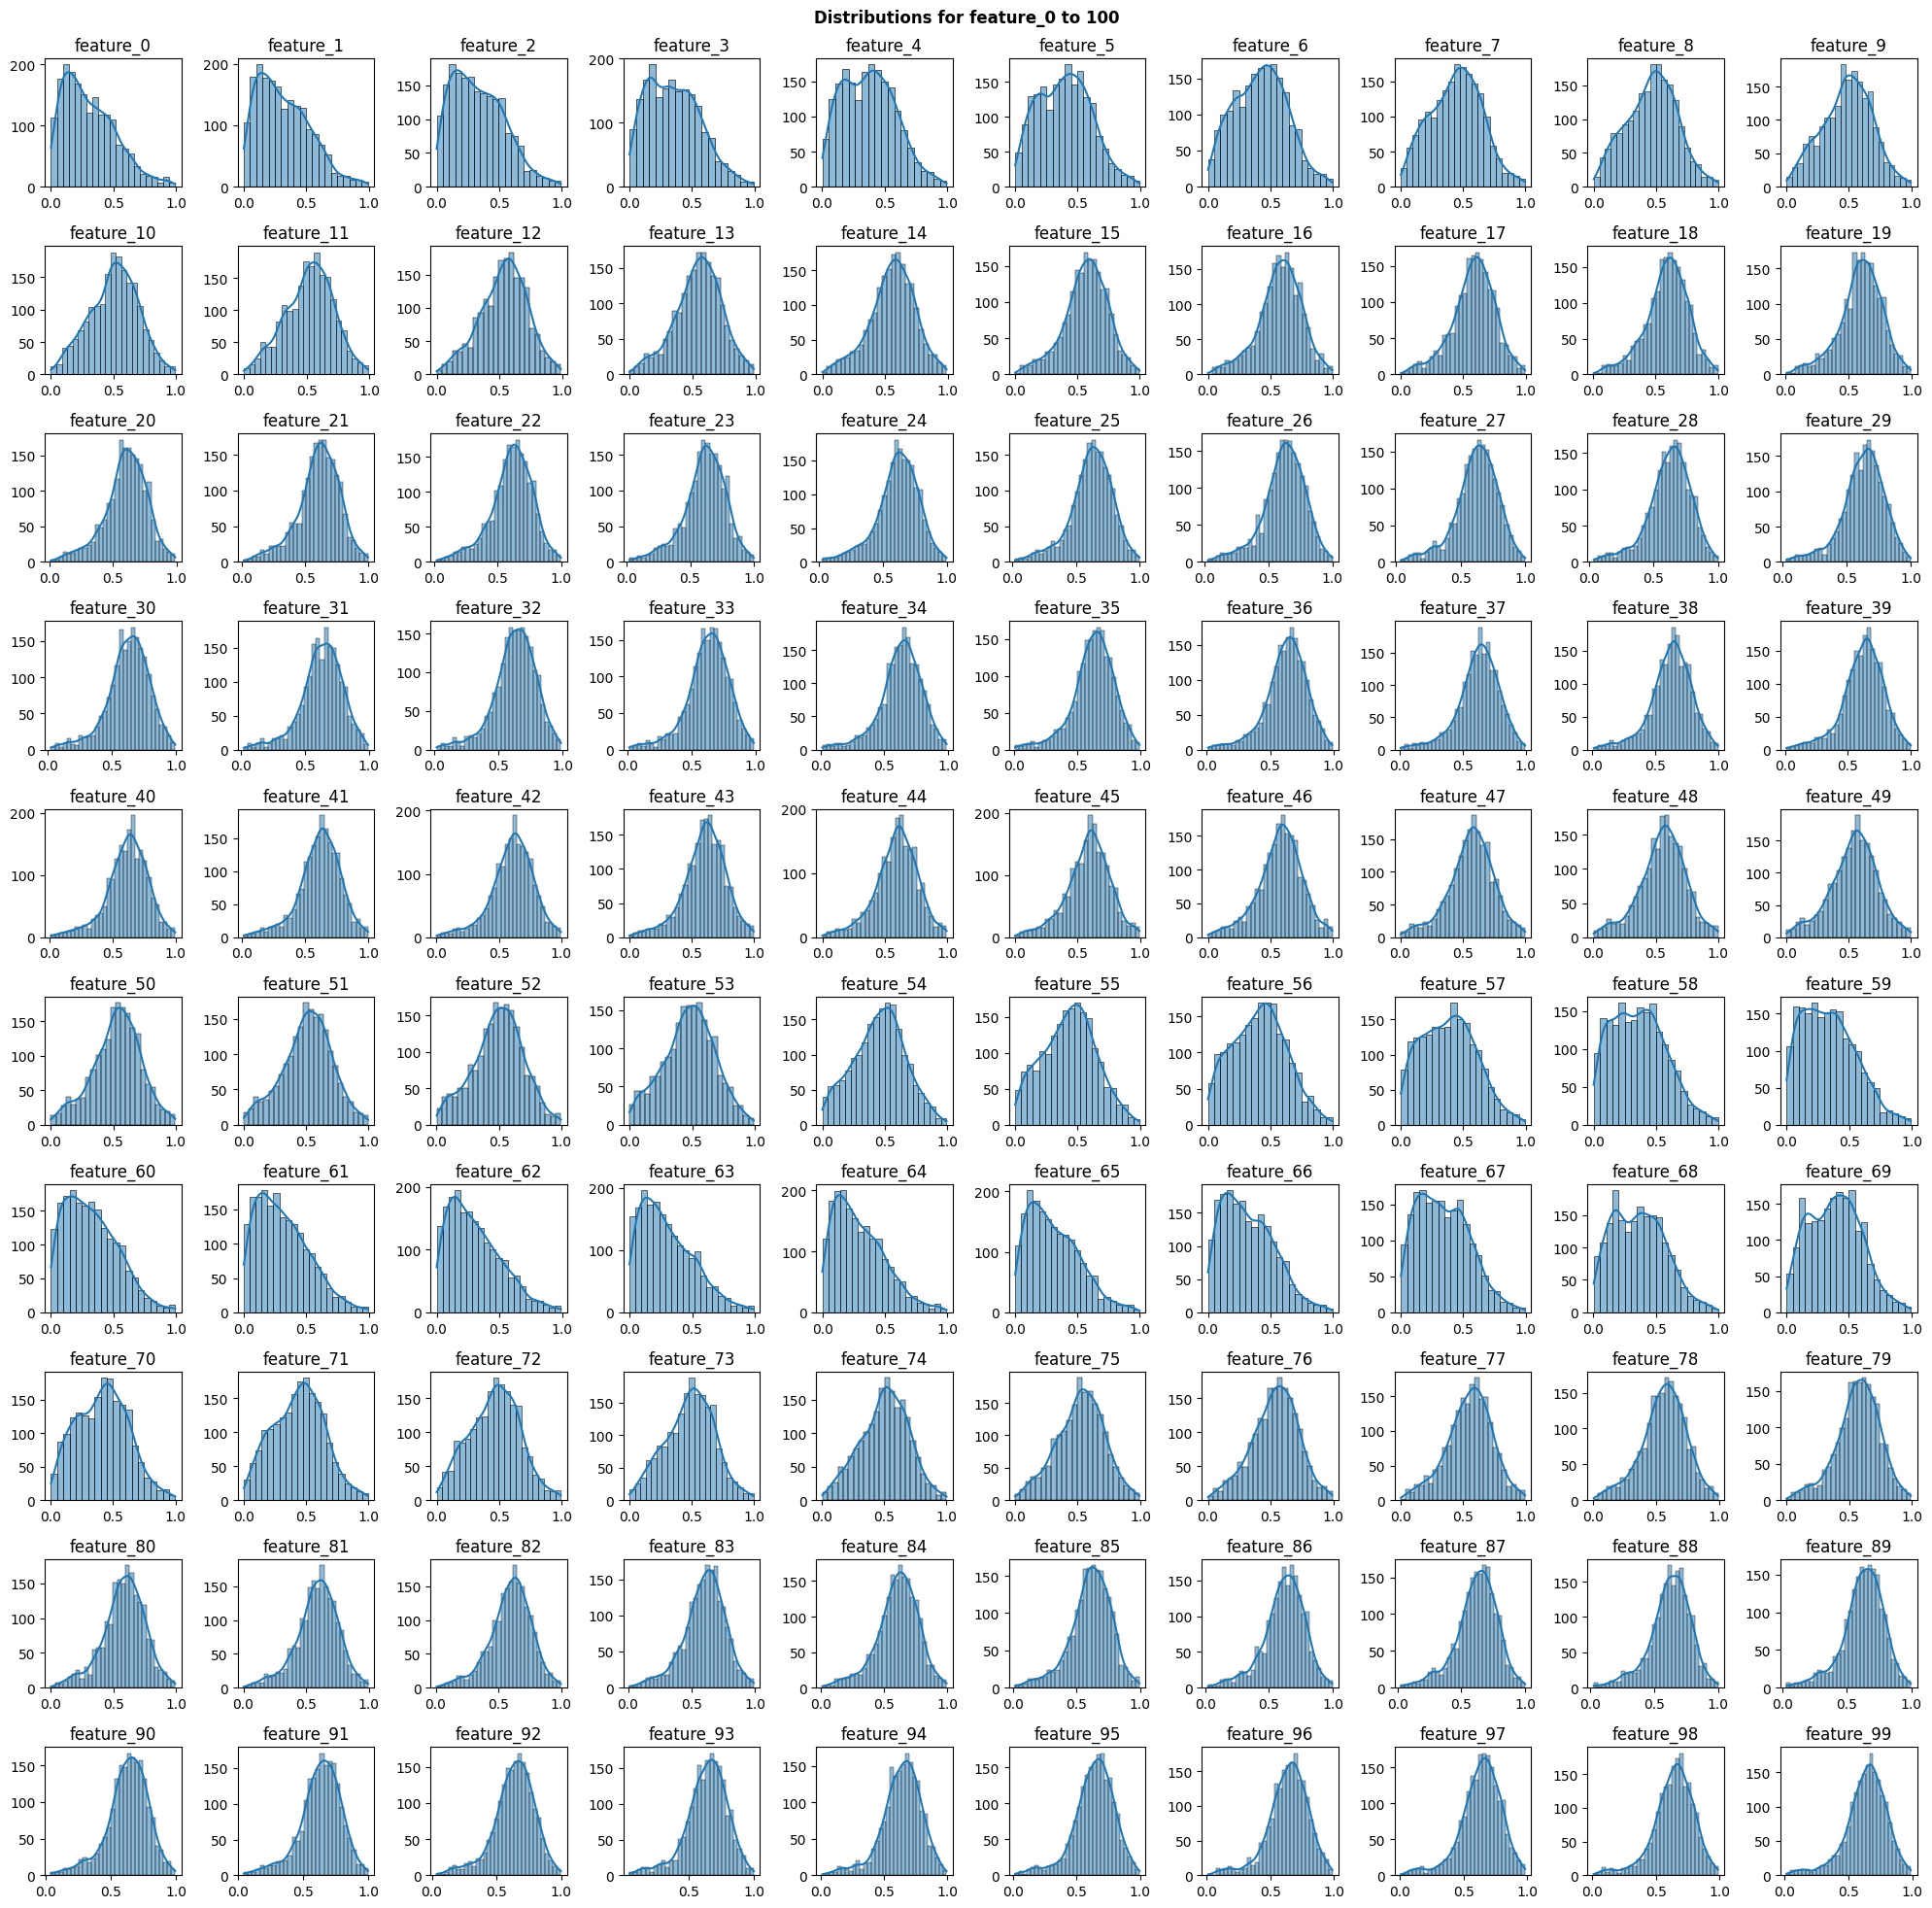

In [393]:
# Plot features 0 to 100
get_distributions(
    data=X_faces,
    min_feat=0,
    max_feat=100,
    nrows=10,
    ncols=10,
    fig_width=20,
    fig_height=20,
    feat_color=False
)

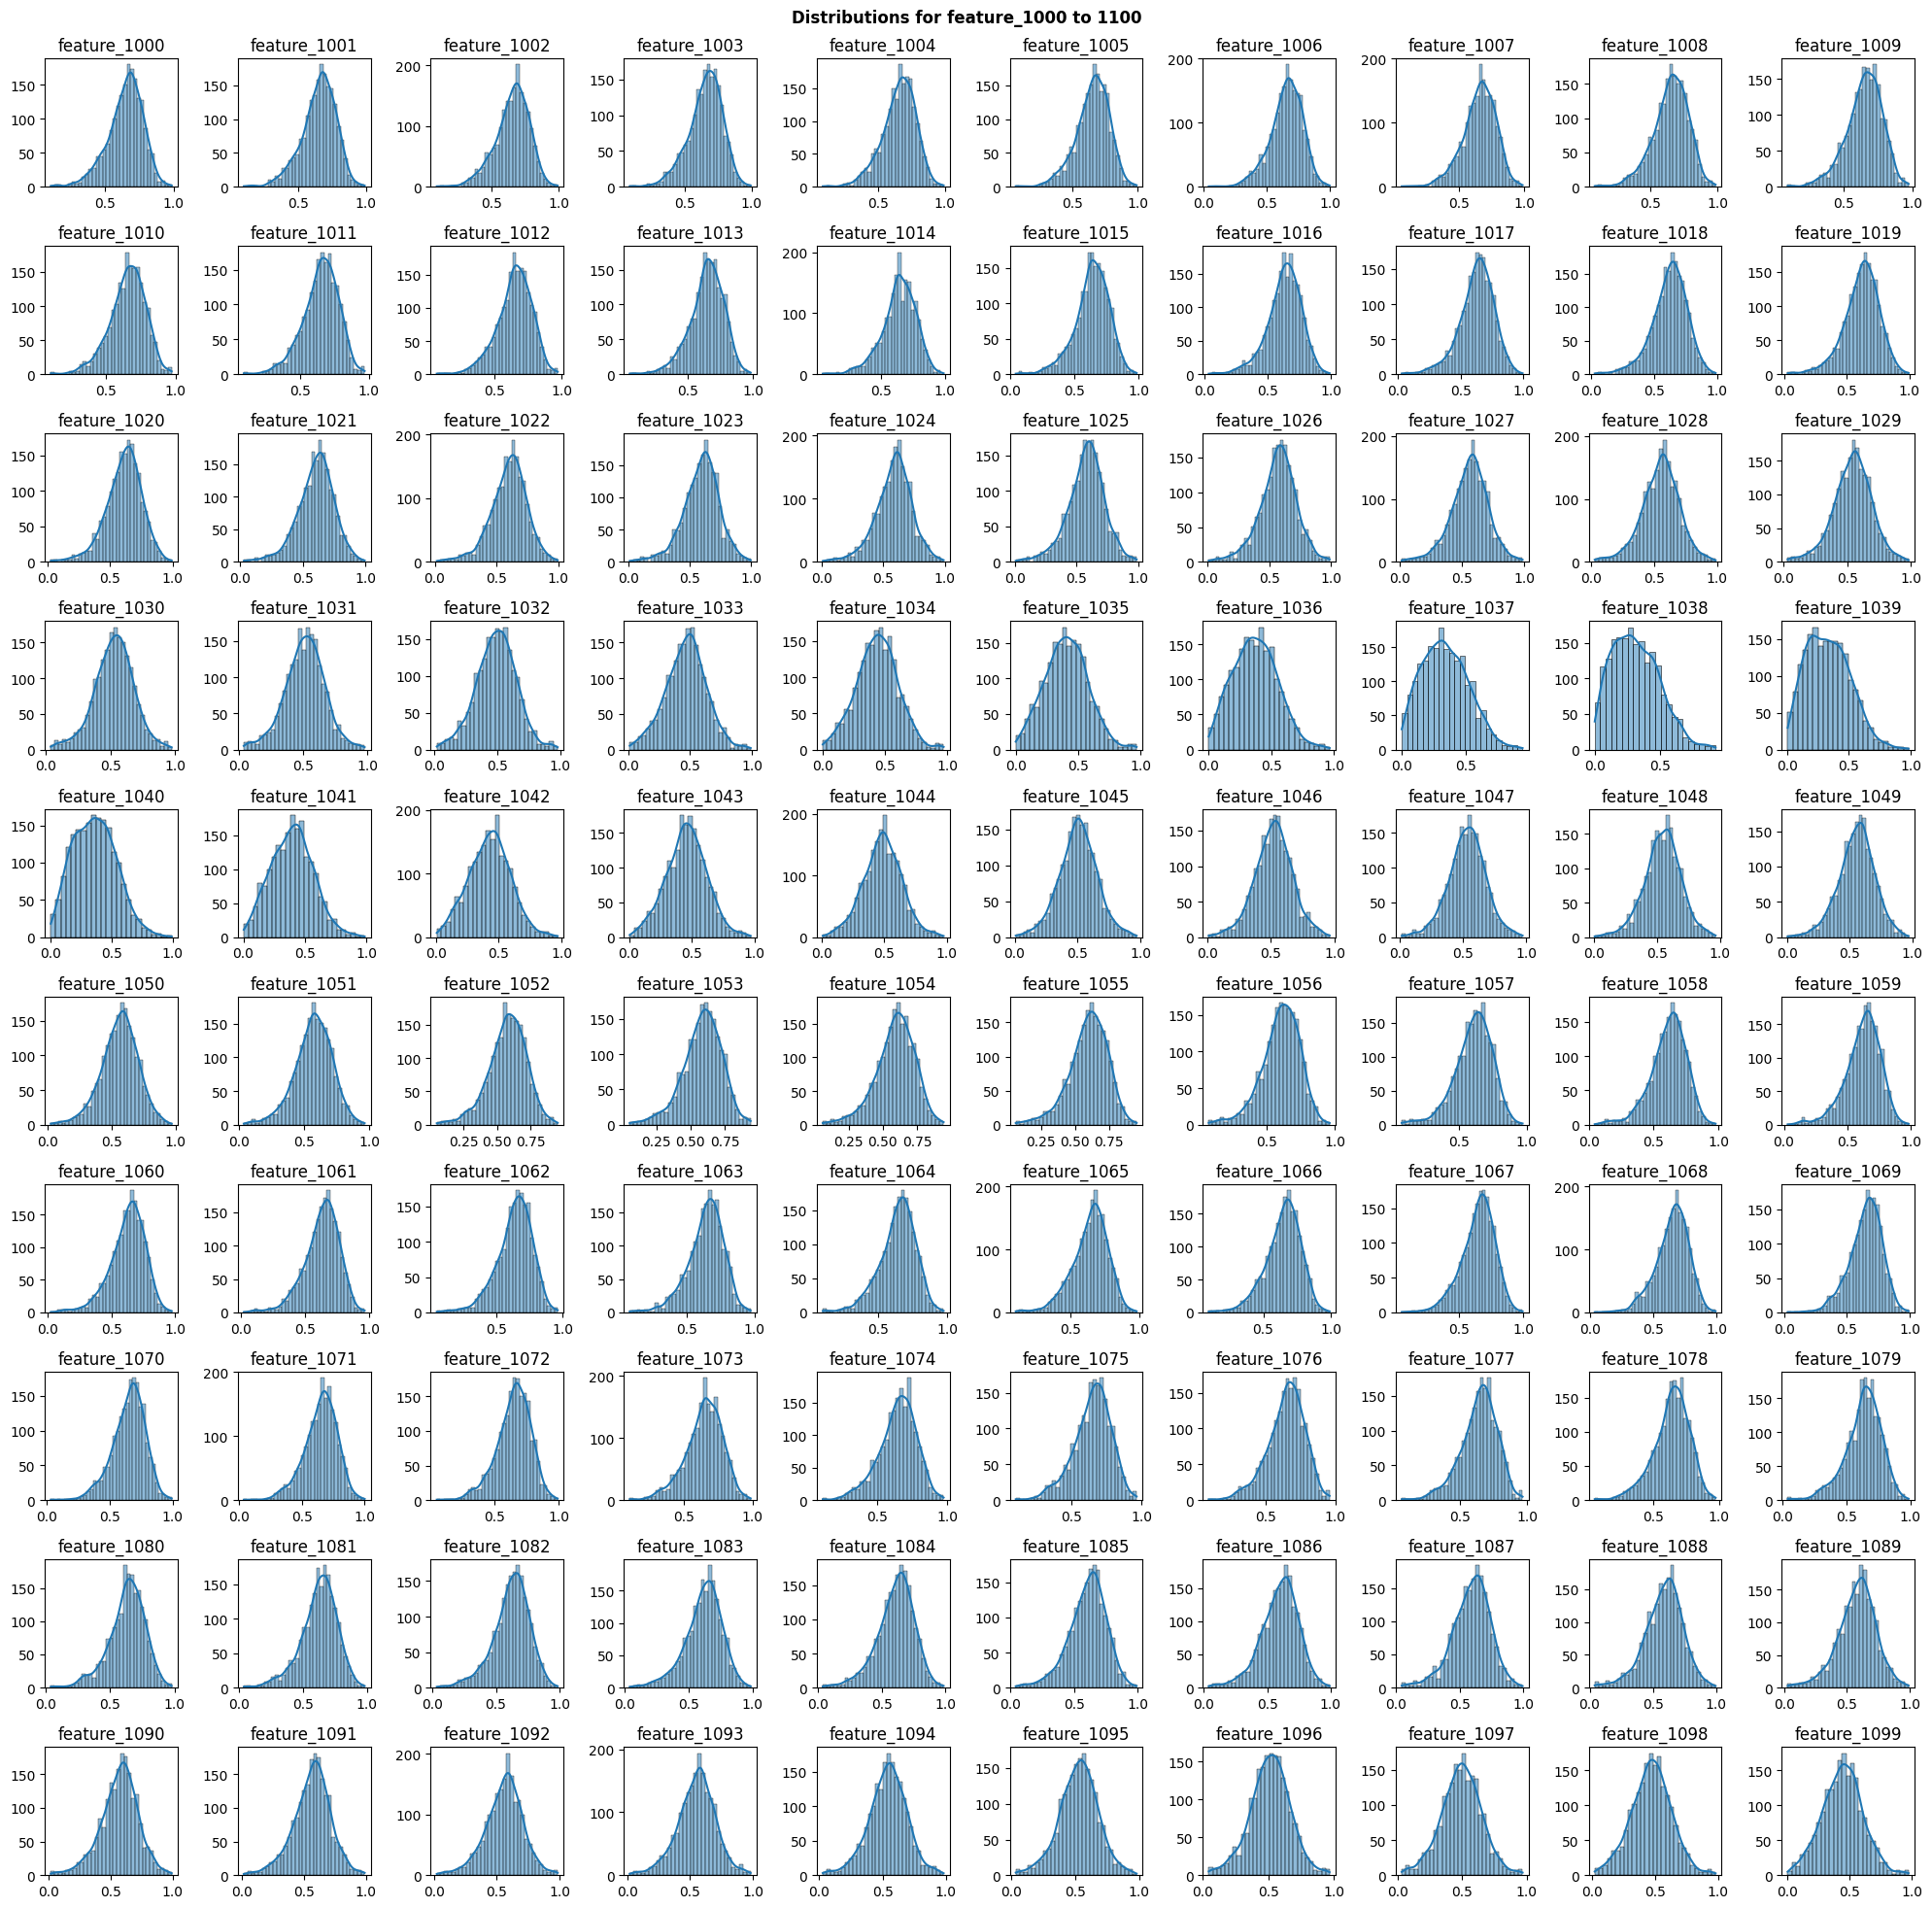

In [394]:
# Plot features 1 000 to 1 100 
get_distributions(
    data=X_faces,
    min_feat=1000,
    max_feat=1100,
    nrows=10,
    ncols=10,
    fig_width=20,
    fig_height=20,
    feat_color=False
)

We see that in the first plots, some of the distributions don't look normal, while a lot of them in the feat1000-1100 plot seem to follow a Gaussian dist.

Since there are 5655 features and 1916 objects, it is hard to visualize the normality of each feature or even to test the normality with a statistical approach sur as the Shapiro test since the latter's p-val is influenced by the sample size and cannot be correctly interpreted at large sample sizes

**We could introduce noise by sampling from a uniform distribution which assigns equal probabilities to all values within a given range and see the results**

In [370]:
# Pixel vals should fall with 0-1 when normalized by 255
print(np.min(X_faces))
print(np.max(X_faces))

0.0
1.0


However, we will use the min and max of each feature accross all objets instead of the whole dataset (axis=0) when sampling from the uniform distribution

In [386]:
def robustness_to_uniform_noise(X_data: np.ndarray, clustering_instance: Union[sklearn.cluster._kmeans.KMeans, sklearn.cluster._dbscan.DBSCAN], hyperparam_value: float, noise_percent: int)-> float:
    """
    Calculates the robustness score of a clustering algorithm to noise introduction by sampling from a uniform distribution.

    Parameters
    ----------
    X_data : np.ndarray
        The data to cluster.
    clustering_instance : Union[]
        An instance of one of scikit-learn's clustering algorithms KMeans or DBSCAN
    hyperparam_value : float 
        The hyperparemeter value of the given clustering algorithm (k for KMeans and eps for DBSCAN)
    noise_percent : int
        The amount of noise to introduce in the dataset

    Returns
    -------
    float:
        The robustness score using the noise introduction
    
    Raises
    ------
    TypeError:
        If noise_percent is not an integer
    ValueError:
        If noise_percent is not between 1 and 99
    TypeError:
        If one of clustering_instance is not an instance of KMeans() or DBSCAN()

    """
    
    # Validate noise_percent
    try:
        noise_percent = int(noise_percent)
    except:
        raise TypeError("noise_percent must be an integer")
    
    if not 0 < noise_percent < 100:
        raise ValueError("noise_percent must fall within 1 and 99")
    
    # Selecting clustering algo
    kmeans = False
    dbscan = False

    if isinstance(clustering_instance, sklearn.cluster._kmeans.KMeans):
        kmeans = True
    elif isinstance(clustering_instance, sklearn.cluster._dbscan.DBSCAN):
        dbscan = True
    else:
        raise TypeError("Use one of default instances of KMeans() or DBSCAN() for clustering_instance")

    # Calculate mean and standard dev for each dimension/pixel
    minimums = np.min(X_data, axis=0)
    maximums = np.max(X_data, axis=0)

    # Calculate noise matrix size from data and noise percent
    noise_m = int(np.round(noise_percent/100*len(X_data)))
    noise_n = X_data.shape[1]

    # Generate noisy datasets by sampling from the normal distribution
    fixed_noisy_datasets = {}
    print(f"Generating 10 noisy datasets of size {noise_m} ({noise_percent}% of X dataset size) by sampling from the uniform distribution...")

    for i in range(10):
        np.random.seed(i)    # Avoid same noise for each generation
        noise_matrix = np.random.uniform(minimums, maximums, size=(noise_m, noise_n))
        fixed_noisy_datasets[f"noise_{i}"] = noise_matrix

    # Perform clusterings with first entry as noiseless iteration
    clusterings = []
    if kmeans:
        km = clustering_instance.set_params(n_clusters=hyperparam_value, random_state=0, n_init="auto")
        print(f"Training first iteration with noiseless data using {km}")
        km.fit(X_data)
        clusterings.append(km.labels_)

    if dbscan:
        dbs = clustering_instance.set_params(eps=hyperparam_value, min_samples=3)
        print(f"Training first iteration with noiseless data using {dbs}")
        dbs.fit(X_data)
        clusterings.append(dbs.labels_)
    
    # Add noise to dataset (with noiseless iteration), train and calculate
    print("Performing clusterings with noisy datasets...")
    for noisy_set in fixed_noisy_datasets:
        if kmeans:
            km.fit(np.append(X_data, fixed_noisy_datasets[noisy_set], axis=0))
            clusterings.append(km.labels_)

        if dbscan:
            dbs.fit(np.append(X_data, fixed_noisy_datasets[noisy_set], axis=0))
            clusterings.append(dbs.labels_)

    # Calculate robustness score
    robust_n = len(clusterings)
    robust_m = len(X_data)
    robust_P = set()
    robust_count = {}

    # Check all pairs if present in same cluster in at least 2 clusterings
    print("Calculating robustness scores...")
    for clustering in clusterings:
        for i in range(robust_m):
            for j in range(i + 1, robust_m):
                if clustering[i] == clustering[j]:
                    robust_P.add((i, j))
                    # Adding all possible pair occurences in count dict
                    if (i, j) in robust_count:
                        robust_count[(i, j)] += 1
                    else:
                        robust_count[(i, j)] = 1
    t = sum(robust_count.values())

    R = t / (len(robust_P) * robust_n)
    print(f"Robustness for {str(clustering_instance)} with {noise_percent}% noise: \nR={R:.4f}\n")
    
    return R      
    

In [387]:
robustness_noise_scores_uniform = {}

for k in k_to_test:
    robustness_noise_scores_uniform[f"kmeans_{k}"] = robustness_to_uniform_noise(
        X_data=X_faces,
        clustering_instance=KMeans(),
        hyperparam_value=k,
        noise_percent=5
    )

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using KMeans(n_clusters=40, n_init='auto', random_state=0)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for KMeans(n_clusters=40, n_init='auto', random_state=0) with 5% noise: 
R=0.2399

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using KMeans(n_clusters=60, n_init='auto', random_state=0)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for KMeans(n_clusters=60, n_init='auto', random_state=0) with 5% noise: 
R=0.2175

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using KMeans(n_clusters=80, n_init='auto', random_state=0)
Performing cluster

In [388]:
for eps in eps_to_test:
    robustness_noise_scores_uniform[f"dbscan_{eps}"] = robustness_to_uniform_noise(
        X_data=X_faces,
        clustering_instance=DBSCAN(),
        hyperparam_value=eps,
        noise_percent=5
    )

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using DBSCAN(eps=7, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=7, min_samples=3) with 5% noise: 
R=1.0000

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using DBSCAN(eps=8, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=8, min_samples=3) with 5% noise: 
R=1.0000

Generating 10 noisy datasets of size 96 (5% of X dataset size) by sampling from the uniform distribution...
Training first iteration with noiseless data using DBSCAN(eps=9, min_samples=3)
Performing clusterings with noisy datasets...
Calculating robustness scores...
Robustness for DBSCAN(eps=9, min_samples=3) with 5% noise: 

In [395]:
print(robustness_noise_scores_uniform)

{'kmeans_40': 0.23985312354292979, 'kmeans_60': 0.21745504149841455, 'kmeans_80': 0.20670240246995944, 'dbscan_7': 1.0, 'dbscan_8': 1.0, 'dbscan_9': 1.0}


**Overall the robustness scores are very similar accross the board. The models (both KMeans and DBSCAN) perform just as well in terms of constant predictions accross clusterings when introducing either uniform or Gaussian noise**